### ローソク足の描画
1分のローソク足データを用いて、10分ごとのローソク足チャートを4時間ずつ（合計24本）描画する。

### 正解ラベルの付与
* 1分のローソク足をダウンサンプリングし、1時間、4時間、1日、3日のローソク足チャートを作成する。このデータを用いて、下降/停滞/上昇の3パターンに分類する。
* ここでは、2015年から2020年までのデータを用いて、変化量の分布を推定する。本来、未来の値は利用できないが、傾向分析により得られた結果という位置づけで利用する。
* また、変化量は、推定した分布（正規分布）に従うものとし、人手で決めた閾値で分類する。今回は、閾値を0.3とし、以下のように分類した。

| パターン | 条件 | クラス | ラベル |
| :--- | :--- | :--- | :--- |
| 下降 | 変化量が-0.3以下 | 0 | down |
| 停滞 | 変化量が-0.3より大きく0.3より小さい | 1 | stay |
| 上昇 | 変化量が0.3以上 | 2 | up |

In [1]:
import os
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

In [2]:
class AnalysisCandleChart:
    """
    ローソク足チャートの分析
    
    Attributes
    ----------
    grouping_rule : str
        チャートをグループ化する際のルール
        デフォルト：4時間ごと
    pca : PCA
        主成分分析処理用のインスタンス
    """
    
    def __init__(self, grouping_rule='4H', pca=None):
        """
        コンストラクタ
        
        Parameters
        ----------
        grouping_rule : str
            チャートをグループ化する際のルール
            デフォルト：4時間ごと
        pca : PCA
            主成分分析処理用のインスタンス
        """
        self.grouping_rule = grouping_rule
        self.pca = pca

    def downsampling(self, df, rule):
        """
        ダウンサンプリング処理
        
        Parameters
        ----------
        df : DataFrame
            ダウンサンプリング対象のDataFrame
        rule : str
            サンプリング時のルール
            
        Returns
        -------
        downsampling_df : DataFrame
            ダウンサンプリングされたDataFrame
        """
        downsampling_df = df.resample(rule).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}).dropna()
        
        return downsampling_df

    def diff_func(self, series):
        """
        変化量の算出処理
        
        Parameters
        ----------
        series : Series
            処理対象のSeries
            
        Returns
        -------
        diff : Series
            変化量
        """
        diff = series.pct_change(1).shift(-1)
        diff = diff.fillna(diff.mean())
        
        return diff

    def estimate_diff(self, df):
        """
        変化量の推定処理
        
        Parameters
        ----------
        df : DataFrame
            処理対象のDataFrame
        pca : PCA
            次元圧縮に利用する
            
        Returns
        -------
        diff : Series
            推定した変化量
        """
        # ダウンサンプリングしたローソク足チャートの作成
        dfs = {
            'hour':      self.downsampling(df, 'H'),  # 1時間のローソク足チャート
            'one_sixth': self.downsampling(df, '4H'), # 4時間のローソク足チャート
            '1day':      self.downsampling(df, 'D'),  # 1日のローソク足チャート
            '3days':     self.downsampling(df, '3D'), # 3日のローソク足チャート
        }
        # データごとに変化量を計算
        diffs = {key: self.diff_func(target['close']) for key, target in dfs.items()}
        # インデックスの作成
        indices = pd.concat([series.index.to_series() for series in diffs.values()]).drop_duplicates().sort_values()
        # DataFrameの作成
        diff_df = pd.DataFrame(data=np.nan, index=indices, columns=list(dfs.keys()))
        # データが存在する部分を更新
        for key, series in diffs.items():
            index = series.index.to_series().apply(lambda time: time.strftime('%Y/%m/%d %H:%M'))
            diff_df.loc[index, key] = series
        # 線形補間
        diff_df = diff_df.interpolate()
        # ダウンサンプリングした結果から変化量を推定
        if self.pca is None:
            self.pca = PCA(n_components=1)
            self.pca.fit(diff_df)
        feature = self.pca.transform(diff_df)
        series = pd.Series(feature.flatten(), index=diff_df.index)
        # グループ化する際のルールを用いて、平均的な変化量を算出
        diff = series.resample(self.grouping_rule).mean()
        
        return diff

class CreateDataset(AnalysisCandleChart):
    """
    データセットの作成
    
    Attributes
    ----------
    root_dir : str
        データセットのルートディレクトリ
    chart_rule : str
        出力するチャートのルール
        デフォルト：10分毎
    threshold : float
        変化量の閾値
        デフォルト：0.1
    mean : float
        変化量の平均値
    std : float
        変化量の標準偏差
    """
    
    def __init__(self, diff, root_dir='chart', chart_rule='10T', threshold=0.1, **kwargs):
        """
        コンストラクタ
        
        Parameters
        ----------
        diff : Series
            推定した変化量
        root_dir : str
            データセットのルートディレクトリ
        chart_rule : str
            出力するチャートのルール
            デフォルト：10分毎
        threshold : float
            変化量の閾値
            デフォルト：0.1
        """
        super().__init__(**kwargs)
        self.root_dir = root_dir
        self.chart_rule = chart_rule
        self.threshold = threshold
        self.mean = diff.mean()
        self.std = diff.std()
        
    def __get_basedir(self, timestamp):
        """
        チャート格納先のbase directory
        
        Parameters
        ----------
        timestamp : datetime
            チャートの時間情報
            
        Returns
        -------
        base_dir : str
            base directory
        """
        base_dir = os.path.join(self.root_dir, timestamp.strftime('%Y/%m'))
        
        return base_dir

    def __get_output_path(self, timestamp):
        """
        出力ファイルパスの取得
        
        Parameters
        ----------
        timestamp : datetime
            チャートの時間情報
            
        Returns
        -------
        output_path : str
            出力ファイルパス
        """
        output_filename = 'fig{}.png'.format(timestamp.strftime('%Y%m%d%H%M'))
        output_path = os.path.join(self.__get_basedir(timestamp), output_filename)
        
        return output_path

    def output_candle_chart(self, df):
        """
        ローソク足チャートの出力
        
        Parameters
        ----------
        df : DataFrame
            処理対象のDataFrame
        """
        # チャートを表示する間隔でダウンサンプリング
        downsampling_df = self.downsampling(df, self.chart_rule)
        # 出力先のディレクトリ作成
        dir_pathes = downsampling_df.index.to_series().apply(self.__get_basedir).drop_duplicates().to_list()
        for dir_path in dir_pathes:
            os.makedirs(dir_path, exist_ok=True)
        # figureの生成
        fig = mpf.figure(style='yahoo', figsize=(3, 3))
        # 余白の設定
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Axesの生成
        ax = fig.add_subplot(1, 1, 1)
        # グルーピングしてプロット
        grouped = filter(lambda xs: not xs[1].empty, downsampling_df.groupby(pd.Grouper(freq=self.grouping_rule)))
        for timestamp, target_df in grouped:
            print(timestamp.strftime('%Y/%m/%d %H:%M'))
            mpf.plot(target_df, type='candle', ax=ax, tight_layout=True)
            # ラベルを削除
            ax.grid(False)
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.axis('off')
            fig.savefig(self.__get_output_path(timestamp))
            ax.clear()

        plt.close(fig)
        
    # チャートから正解ラベルを生成
    def create_groundtruth(self, df):
        # 変化量の取得
        series = self.estimate_diff(df)
        series_std = (series - self.mean) / self.std
        # DataFrameの用意
        indices = self.downsampling(df, self.grouping_rule).index
        ret_df = pd.DataFrame(index=indices, columns=['path', 'class', 'label'])
        ret_df['path'] = indices.to_series().apply(self.__get_output_path)
        # 初期化（下降）
        ret_df['class'] = 0
        ret_df['label'] = 'down'
        # 「停滞する」部分の抽出
        judge = series_std.abs() < self.threshold
        ret_df.loc[judge, 'class'] = 1
        ret_df.loc[judge, 'label'] = 'stay'
        # 「上昇する」部分の抽出
        judge = series_std >= self.threshold
        ret_df.loc[judge, 'class'] = 2
        ret_df.loc[judge, 'label'] = 'up'

        return ret_df
    
    # データセットの出力
    def output_dataset(self, df, output_filename):
        df.to_csv(output_filename, header=True, index=False)
        
# ヒストグラムの描画
def plot_histogram(diff, mean, std, threshold=0.1):
    """
    ヒストグラムの描画
    
    Parameters
    ----------
    diff : Series
        推定した変化量
    mean : float
        平均値
    std : float
        標準偏差
    threshold : float
        変化量の閾値
        デフォルト：0.1
    """
    diff_std = (diff - mean) / std
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Distribution of pct_change')
    ax.set_xlabel('pct_change')
    ax.set_ylabel('frequency')
    ax.set_ylim(0, 1.0)
    ax.grid(False)
    judge = diff_std.abs() < threshold
    ax.hist(diff_std,        bins=500, range=(-5,5), density=True, alpha=0.3, color='b')
    ax.hist(diff_std[judge], bins=500, range=(-5,5), density=True, alpha=0.3, color='r')
    # 閾値以内に入っているデータをカウント
    matched = diff_std[judge].count()
    total = diff_std.count()
    print('matched / total: {} / {} ({:.3%})'.format(matched, total, matched / total))
    
    return ax

In [3]:
# データの読み込み
df = pd.read_csv('csv/concat_USDJPY2015_2020.csv', index_col='datetime', parse_dates=True)

In [4]:
# ================
# データセット作成
# ================
create_chart = True
threshold = 0.3
train_output_filename = 'train_dataset.csv'
test_output_filename = 'test_dataset.csv'
train_df = df[:'2019'].copy()
test_df = df['2020'].copy()

mean: -8.482049507170376e-06
std:  6.533415452607525e-03
matched / total: 3023 / 9519 (31.758%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

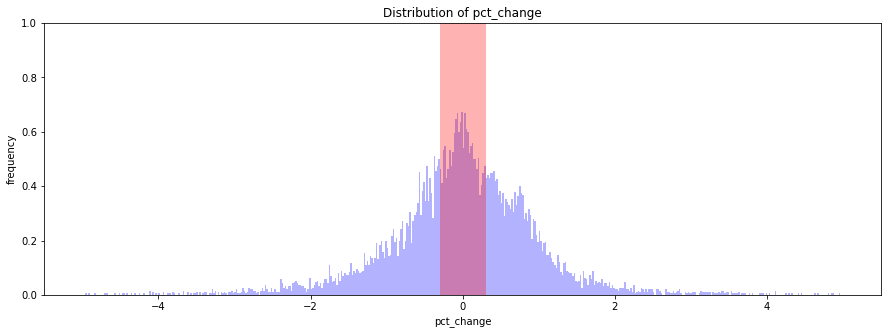

In [5]:
analyzer = AnalysisCandleChart()
diff = analyzer.estimate_diff(df)
mean, std = diff.mean(), diff.std()
print('mean: {:.15e}'.format(mean))
print('std:  {:.15e}'.format(std))
plot_histogram(diff, mean, std, threshold=threshold)

In [6]:
creater = CreateDataset(diff, threshold=threshold, pca=analyzer.pca)
creater.output_dataset(creater.create_groundtruth(train_df), train_output_filename)
creater.output_dataset(creater.create_groundtruth(test_df), test_output_filename)

if create_chart:
    creater.output_candle_chart(train_df)
    creater.output_candle_chart(test_df)

2015/01/02 00:00
2015/01/02 04:00
2015/01/02 08:00
2015/01/02 12:00
2015/01/02 16:00
2015/01/02 20:00
2015/01/05 00:00
2015/01/05 04:00
2015/01/05 08:00
2015/01/05 12:00
2015/01/05 16:00
2015/01/05 20:00
2015/01/06 00:00
2015/01/06 04:00
2015/01/06 08:00
2015/01/06 12:00
2015/01/06 16:00
2015/01/06 20:00
2015/01/07 00:00
2015/01/07 04:00
2015/01/07 08:00
2015/01/07 12:00
2015/01/07 16:00
2015/01/07 20:00
2015/01/08 00:00
2015/01/08 04:00
2015/01/08 08:00
2015/01/08 12:00
2015/01/08 16:00
2015/01/08 20:00
2015/01/09 00:00
2015/01/09 04:00
2015/01/09 08:00
2015/01/09 12:00
2015/01/09 16:00
2015/01/09 20:00
2015/01/12 00:00
2015/01/12 04:00
2015/01/12 08:00
2015/01/12 12:00
2015/01/12 16:00
2015/01/12 20:00
2015/01/13 00:00
2015/01/13 04:00
2015/01/13 08:00
2015/01/13 12:00
2015/01/13 16:00
2015/01/13 20:00
2015/01/14 00:00
2015/01/14 04:00
2015/01/14 08:00
2015/01/14 12:00
2015/01/14 16:00
2015/01/14 20:00
2015/01/15 00:00
2015/01/15 04:00
2015/01/15 08:00
2015/01/15 12:00
2015/01/15 16:

2015/04/24 08:00
2015/04/24 12:00
2015/04/24 16:00
2015/04/24 20:00
2015/04/27 00:00
2015/04/27 04:00
2015/04/27 08:00
2015/04/27 12:00
2015/04/27 16:00
2015/04/27 20:00
2015/04/28 00:00
2015/04/28 04:00
2015/04/28 08:00
2015/04/28 12:00
2015/04/28 16:00
2015/04/28 20:00
2015/04/29 00:00
2015/04/29 04:00
2015/04/29 08:00
2015/04/29 12:00
2015/04/29 16:00
2015/04/29 20:00
2015/04/30 00:00
2015/04/30 04:00
2015/04/30 08:00
2015/04/30 12:00
2015/04/30 16:00
2015/04/30 20:00
2015/05/01 00:00
2015/05/01 04:00
2015/05/01 08:00
2015/05/01 12:00
2015/05/01 16:00
2015/05/01 20:00
2015/05/04 00:00
2015/05/04 04:00
2015/05/04 08:00
2015/05/04 12:00
2015/05/04 16:00
2015/05/04 20:00
2015/05/05 00:00
2015/05/05 04:00
2015/05/05 08:00
2015/05/05 12:00
2015/05/05 16:00
2015/05/05 20:00
2015/05/06 00:00
2015/05/06 04:00
2015/05/06 08:00
2015/05/06 12:00
2015/05/06 16:00
2015/05/06 20:00
2015/05/07 00:00
2015/05/07 04:00
2015/05/07 08:00
2015/05/07 12:00
2015/05/07 16:00
2015/05/07 20:00
2015/05/08 00:

2015/08/17 00:00
2015/08/17 04:00
2015/08/17 08:00
2015/08/17 12:00
2015/08/17 16:00
2015/08/17 20:00
2015/08/18 00:00
2015/08/18 04:00
2015/08/18 08:00
2015/08/18 12:00
2015/08/18 16:00
2015/08/18 20:00
2015/08/19 00:00
2015/08/19 04:00
2015/08/19 08:00
2015/08/19 12:00
2015/08/19 16:00
2015/08/19 20:00
2015/08/20 00:00
2015/08/20 04:00
2015/08/20 08:00
2015/08/20 12:00
2015/08/20 16:00
2015/08/20 20:00
2015/08/21 00:00
2015/08/21 04:00
2015/08/21 08:00
2015/08/21 12:00
2015/08/21 16:00
2015/08/21 20:00
2015/08/24 00:00
2015/08/24 04:00
2015/08/24 08:00
2015/08/24 12:00
2015/08/24 16:00
2015/08/24 20:00
2015/08/25 00:00
2015/08/25 04:00
2015/08/25 08:00
2015/08/25 12:00
2015/08/25 16:00
2015/08/25 20:00
2015/08/26 00:00
2015/08/26 04:00
2015/08/26 08:00
2015/08/26 12:00
2015/08/26 16:00
2015/08/26 20:00
2015/08/27 00:00
2015/08/27 04:00
2015/08/27 08:00
2015/08/27 12:00
2015/08/27 16:00
2015/08/27 20:00
2015/08/28 00:00
2015/08/28 04:00
2015/08/28 08:00
2015/08/28 12:00
2015/08/28 16:

2015/12/08 00:00
2015/12/08 04:00
2015/12/08 08:00
2015/12/08 12:00
2015/12/08 16:00
2015/12/08 20:00
2015/12/09 00:00
2015/12/09 04:00
2015/12/09 08:00
2015/12/09 12:00
2015/12/09 16:00
2015/12/09 20:00
2015/12/10 00:00
2015/12/10 04:00
2015/12/10 08:00
2015/12/10 12:00
2015/12/10 16:00
2015/12/10 20:00
2015/12/11 00:00
2015/12/11 04:00
2015/12/11 08:00
2015/12/11 12:00
2015/12/11 16:00
2015/12/11 20:00
2015/12/14 00:00
2015/12/14 04:00
2015/12/14 08:00
2015/12/14 12:00
2015/12/14 16:00
2015/12/14 20:00
2015/12/15 00:00
2015/12/15 04:00
2015/12/15 08:00
2015/12/15 12:00
2015/12/15 16:00
2015/12/15 20:00
2015/12/16 00:00
2015/12/16 04:00
2015/12/16 08:00
2015/12/16 12:00
2015/12/16 16:00
2015/12/16 20:00
2015/12/17 00:00
2015/12/17 04:00
2015/12/17 08:00
2015/12/17 12:00
2015/12/17 16:00
2015/12/17 20:00
2015/12/18 00:00
2015/12/18 04:00
2015/12/18 08:00
2015/12/18 12:00
2015/12/18 16:00
2015/12/18 20:00
2015/12/21 00:00
2015/12/21 04:00
2015/12/21 08:00
2015/12/21 12:00
2015/12/21 16:

2016/04/04 00:00
2016/04/04 04:00
2016/04/04 08:00
2016/04/04 12:00
2016/04/04 16:00
2016/04/04 20:00
2016/04/05 00:00
2016/04/05 04:00
2016/04/05 08:00
2016/04/05 12:00
2016/04/05 16:00
2016/04/05 20:00
2016/04/06 00:00
2016/04/06 04:00
2016/04/06 08:00
2016/04/06 12:00
2016/04/06 16:00
2016/04/06 20:00
2016/04/07 00:00
2016/04/07 04:00
2016/04/07 08:00
2016/04/07 12:00
2016/04/07 16:00
2016/04/07 20:00
2016/04/08 00:00
2016/04/08 04:00
2016/04/08 08:00
2016/04/08 12:00
2016/04/08 16:00
2016/04/08 20:00
2016/04/11 00:00
2016/04/11 04:00
2016/04/11 08:00
2016/04/11 12:00
2016/04/11 16:00
2016/04/11 20:00
2016/04/12 00:00
2016/04/12 04:00
2016/04/12 08:00
2016/04/12 12:00
2016/04/12 16:00
2016/04/12 20:00
2016/04/13 00:00
2016/04/13 04:00
2016/04/13 08:00
2016/04/13 12:00
2016/04/13 16:00
2016/04/13 20:00
2016/04/14 00:00
2016/04/14 04:00
2016/04/14 08:00
2016/04/14 12:00
2016/04/14 16:00
2016/04/14 20:00
2016/04/15 00:00
2016/04/15 04:00
2016/04/15 08:00
2016/04/15 12:00
2016/04/15 16:

2016/07/26 08:00
2016/07/26 12:00
2016/07/26 16:00
2016/07/26 20:00
2016/07/27 00:00
2016/07/27 04:00
2016/07/27 08:00
2016/07/27 12:00
2016/07/27 16:00
2016/07/27 20:00
2016/07/28 00:00
2016/07/28 04:00
2016/07/28 08:00
2016/07/28 12:00
2016/07/28 16:00
2016/07/28 20:00
2016/07/29 00:00
2016/07/29 04:00
2016/07/29 08:00
2016/07/29 12:00
2016/07/29 16:00
2016/07/29 20:00
2016/08/01 00:00
2016/08/01 04:00
2016/08/01 08:00
2016/08/01 12:00
2016/08/01 16:00
2016/08/01 20:00
2016/08/02 00:00
2016/08/02 04:00
2016/08/02 08:00
2016/08/02 12:00
2016/08/02 16:00
2016/08/02 20:00
2016/08/03 00:00
2016/08/03 04:00
2016/08/03 08:00
2016/08/03 12:00
2016/08/03 16:00
2016/08/03 20:00
2016/08/04 00:00
2016/08/04 04:00
2016/08/04 08:00
2016/08/04 12:00
2016/08/04 16:00
2016/08/04 20:00
2016/08/05 00:00
2016/08/05 04:00
2016/08/05 08:00
2016/08/05 12:00
2016/08/05 16:00
2016/08/05 20:00
2016/08/08 00:00
2016/08/08 04:00
2016/08/08 08:00
2016/08/08 12:00
2016/08/08 16:00
2016/08/08 20:00
2016/08/09 00:

2016/11/15 20:00
2016/11/16 00:00
2016/11/16 04:00
2016/11/16 08:00
2016/11/16 12:00
2016/11/16 16:00
2016/11/16 20:00
2016/11/17 00:00
2016/11/17 04:00
2016/11/17 08:00
2016/11/17 12:00
2016/11/17 16:00
2016/11/17 20:00
2016/11/18 00:00
2016/11/18 04:00
2016/11/18 08:00
2016/11/18 12:00
2016/11/18 16:00
2016/11/18 20:00
2016/11/21 00:00
2016/11/21 04:00
2016/11/21 08:00
2016/11/21 12:00
2016/11/21 16:00
2016/11/21 20:00
2016/11/22 00:00
2016/11/22 04:00
2016/11/22 08:00
2016/11/22 12:00
2016/11/22 16:00
2016/11/22 20:00
2016/11/23 00:00
2016/11/23 04:00
2016/11/23 08:00
2016/11/23 12:00
2016/11/23 16:00
2016/11/23 20:00
2016/11/24 00:00
2016/11/24 04:00
2016/11/24 08:00
2016/11/24 12:00
2016/11/24 16:00
2016/11/24 20:00
2016/11/25 00:00
2016/11/25 04:00
2016/11/25 08:00
2016/11/25 12:00
2016/11/25 16:00
2016/11/25 20:00
2016/11/28 00:00
2016/11/28 04:00
2016/11/28 08:00
2016/11/28 12:00
2016/11/28 16:00
2016/11/28 20:00
2016/11/29 00:00
2016/11/29 04:00
2016/11/29 08:00
2016/11/29 12:

2017/03/10 04:00
2017/03/10 08:00
2017/03/10 12:00
2017/03/10 16:00
2017/03/10 20:00
2017/03/13 00:00
2017/03/13 04:00
2017/03/13 08:00
2017/03/13 12:00
2017/03/13 16:00
2017/03/13 20:00
2017/03/14 00:00
2017/03/14 04:00
2017/03/14 08:00
2017/03/14 12:00
2017/03/14 16:00
2017/03/14 20:00
2017/03/15 00:00
2017/03/15 04:00
2017/03/15 08:00
2017/03/15 12:00
2017/03/15 16:00
2017/03/15 20:00
2017/03/16 00:00
2017/03/16 04:00
2017/03/16 08:00
2017/03/16 12:00
2017/03/16 16:00
2017/03/16 20:00
2017/03/17 00:00
2017/03/17 04:00
2017/03/17 08:00
2017/03/17 12:00
2017/03/17 16:00
2017/03/17 20:00
2017/03/20 00:00
2017/03/20 04:00
2017/03/20 08:00
2017/03/20 12:00
2017/03/20 16:00
2017/03/20 20:00
2017/03/21 00:00
2017/03/21 04:00
2017/03/21 08:00
2017/03/21 12:00
2017/03/21 16:00
2017/03/21 20:00
2017/03/22 00:00
2017/03/22 04:00
2017/03/22 08:00
2017/03/22 12:00
2017/03/22 16:00
2017/03/22 20:00
2017/03/23 00:00
2017/03/23 04:00
2017/03/23 08:00
2017/03/23 12:00
2017/03/23 16:00
2017/03/23 20:

2017/06/30 20:00
2017/07/03 00:00
2017/07/03 04:00
2017/07/03 08:00
2017/07/03 12:00
2017/07/03 16:00
2017/07/03 20:00
2017/07/04 00:00
2017/07/04 04:00
2017/07/04 08:00
2017/07/04 12:00
2017/07/04 16:00
2017/07/04 20:00
2017/07/05 00:00
2017/07/05 04:00
2017/07/05 08:00
2017/07/05 12:00
2017/07/05 16:00
2017/07/05 20:00
2017/07/06 00:00
2017/07/06 04:00
2017/07/06 08:00
2017/07/06 12:00
2017/07/06 16:00
2017/07/06 20:00
2017/07/07 00:00
2017/07/07 04:00
2017/07/07 08:00
2017/07/07 12:00
2017/07/07 16:00
2017/07/07 20:00
2017/07/10 00:00
2017/07/10 04:00
2017/07/10 08:00
2017/07/10 12:00
2017/07/10 16:00
2017/07/10 20:00
2017/07/11 00:00
2017/07/11 04:00
2017/07/11 08:00
2017/07/11 12:00
2017/07/11 16:00
2017/07/11 20:00
2017/07/12 00:00
2017/07/12 04:00
2017/07/12 08:00
2017/07/12 12:00
2017/07/12 16:00
2017/07/12 20:00
2017/07/13 00:00
2017/07/13 04:00
2017/07/13 08:00
2017/07/13 12:00
2017/07/13 16:00
2017/07/13 20:00
2017/07/14 00:00
2017/07/14 04:00
2017/07/14 08:00
2017/07/14 12:

2017/10/23 08:00
2017/10/23 12:00
2017/10/23 16:00
2017/10/23 20:00
2017/10/24 00:00
2017/10/24 04:00
2017/10/24 08:00
2017/10/24 12:00
2017/10/24 16:00
2017/10/24 20:00
2017/10/25 00:00
2017/10/25 04:00
2017/10/25 08:00
2017/10/25 12:00
2017/10/25 16:00
2017/10/25 20:00
2017/10/26 00:00
2017/10/26 04:00
2017/10/26 08:00
2017/10/26 12:00
2017/10/26 16:00
2017/10/26 20:00
2017/10/27 00:00
2017/10/27 04:00
2017/10/27 08:00
2017/10/27 12:00
2017/10/27 16:00
2017/10/27 20:00
2017/10/30 00:00
2017/10/30 04:00
2017/10/30 08:00
2017/10/30 12:00
2017/10/30 16:00
2017/10/30 20:00
2017/10/31 00:00
2017/10/31 04:00
2017/10/31 08:00
2017/10/31 12:00
2017/10/31 16:00
2017/10/31 20:00
2017/11/01 00:00
2017/11/01 04:00
2017/11/01 08:00
2017/11/01 12:00
2017/11/01 16:00
2017/11/01 20:00
2017/11/02 00:00
2017/11/02 04:00
2017/11/02 08:00
2017/11/02 12:00
2017/11/02 16:00
2017/11/02 20:00
2017/11/03 00:00
2017/11/03 04:00
2017/11/03 08:00
2017/11/03 12:00
2017/11/03 16:00
2017/11/03 20:00
2017/11/06 00:

2018/02/15 00:00
2018/02/15 04:00
2018/02/15 08:00
2018/02/15 12:00
2018/02/15 16:00
2018/02/15 20:00
2018/02/16 00:00
2018/02/16 04:00
2018/02/16 08:00
2018/02/16 12:00
2018/02/16 16:00
2018/02/16 20:00
2018/02/19 00:00
2018/02/19 04:00
2018/02/19 08:00
2018/02/19 12:00
2018/02/19 16:00
2018/02/19 20:00
2018/02/20 00:00
2018/02/20 04:00
2018/02/20 08:00
2018/02/20 12:00
2018/02/20 16:00
2018/02/20 20:00
2018/02/21 00:00
2018/02/21 04:00
2018/02/21 08:00
2018/02/21 12:00
2018/02/21 16:00
2018/02/21 20:00
2018/02/22 00:00
2018/02/22 04:00
2018/02/22 08:00
2018/02/22 12:00
2018/02/22 16:00
2018/02/22 20:00
2018/02/23 00:00
2018/02/23 04:00
2018/02/23 08:00
2018/02/23 12:00
2018/02/23 16:00
2018/02/23 20:00
2018/02/26 00:00
2018/02/26 04:00
2018/02/26 08:00
2018/02/26 12:00
2018/02/26 16:00
2018/02/26 20:00
2018/02/27 00:00
2018/02/27 04:00
2018/02/27 08:00
2018/02/27 12:00
2018/02/27 16:00
2018/02/27 20:00
2018/02/28 00:00
2018/02/28 04:00
2018/02/28 08:00
2018/02/28 12:00
2018/02/28 16:

2018/06/07 08:00
2018/06/07 12:00
2018/06/07 16:00
2018/06/07 20:00
2018/06/08 00:00
2018/06/08 04:00
2018/06/08 08:00
2018/06/08 12:00
2018/06/08 16:00
2018/06/08 20:00
2018/06/11 00:00
2018/06/11 04:00
2018/06/11 08:00
2018/06/11 12:00
2018/06/11 16:00
2018/06/11 20:00
2018/06/12 00:00
2018/06/12 04:00
2018/06/12 08:00
2018/06/12 12:00
2018/06/12 16:00
2018/06/12 20:00
2018/06/13 00:00
2018/06/13 04:00
2018/06/13 08:00
2018/06/13 12:00
2018/06/13 16:00
2018/06/13 20:00
2018/06/14 00:00
2018/06/14 04:00
2018/06/14 08:00
2018/06/14 12:00
2018/06/14 16:00
2018/06/14 20:00
2018/06/15 00:00
2018/06/15 04:00
2018/06/15 08:00
2018/06/15 12:00
2018/06/15 16:00
2018/06/15 20:00
2018/06/18 00:00
2018/06/18 04:00
2018/06/18 08:00
2018/06/18 12:00
2018/06/18 16:00
2018/06/18 20:00
2018/06/19 00:00
2018/06/19 04:00
2018/06/19 08:00
2018/06/19 12:00
2018/06/19 16:00
2018/06/19 20:00
2018/06/20 00:00
2018/06/20 04:00
2018/06/20 08:00
2018/06/20 12:00
2018/06/20 16:00
2018/06/20 20:00
2018/06/21 00:

2018/09/28 12:00
2018/09/28 16:00
2018/09/28 20:00
2018/10/01 00:00
2018/10/01 04:00
2018/10/01 08:00
2018/10/01 12:00
2018/10/01 16:00
2018/10/01 20:00
2018/10/02 00:00
2018/10/02 04:00
2018/10/02 08:00
2018/10/02 12:00
2018/10/02 16:00
2018/10/02 20:00
2018/10/03 00:00
2018/10/03 04:00
2018/10/03 08:00
2018/10/03 12:00
2018/10/03 16:00
2018/10/03 20:00
2018/10/04 00:00
2018/10/04 04:00
2018/10/04 08:00
2018/10/04 12:00
2018/10/04 16:00
2018/10/04 20:00
2018/10/05 00:00
2018/10/05 04:00
2018/10/05 08:00
2018/10/05 12:00
2018/10/05 16:00
2018/10/05 20:00
2018/10/08 00:00
2018/10/08 04:00
2018/10/08 08:00
2018/10/08 12:00
2018/10/08 16:00
2018/10/08 20:00
2018/10/09 00:00
2018/10/09 04:00
2018/10/09 08:00
2018/10/09 12:00
2018/10/09 16:00
2018/10/09 20:00
2018/10/10 00:00
2018/10/10 04:00
2018/10/10 08:00
2018/10/10 12:00
2018/10/10 16:00
2018/10/10 20:00
2018/10/11 00:00
2018/10/11 04:00
2018/10/11 08:00
2018/10/11 12:00
2018/10/11 16:00
2018/10/11 20:00
2018/10/12 00:00
2018/10/12 04:

2019/01/23 08:00
2019/01/23 12:00
2019/01/23 16:00
2019/01/23 20:00
2019/01/24 00:00
2019/01/24 04:00
2019/01/24 08:00
2019/01/24 12:00
2019/01/24 16:00
2019/01/24 20:00
2019/01/25 00:00
2019/01/25 04:00
2019/01/25 08:00
2019/01/25 12:00
2019/01/25 16:00
2019/01/25 20:00
2019/01/28 00:00
2019/01/28 04:00
2019/01/28 08:00
2019/01/28 12:00
2019/01/28 16:00
2019/01/28 20:00
2019/01/29 00:00
2019/01/29 04:00
2019/01/29 08:00
2019/01/29 12:00
2019/01/29 16:00
2019/01/29 20:00
2019/01/30 00:00
2019/01/30 04:00
2019/01/30 08:00
2019/01/30 12:00
2019/01/30 16:00
2019/01/30 20:00
2019/01/31 00:00
2019/01/31 04:00
2019/01/31 08:00
2019/01/31 12:00
2019/01/31 16:00
2019/01/31 20:00
2019/02/01 00:00
2019/02/01 04:00
2019/02/01 08:00
2019/02/01 12:00
2019/02/01 16:00
2019/02/01 20:00
2019/02/04 00:00
2019/02/04 04:00
2019/02/04 08:00
2019/02/04 12:00
2019/02/04 16:00
2019/02/04 20:00
2019/02/05 00:00
2019/02/05 04:00
2019/02/05 08:00
2019/02/05 12:00
2019/02/05 16:00
2019/02/05 20:00
2019/02/06 00:

2019/05/15 20:00
2019/05/16 00:00
2019/05/16 04:00
2019/05/16 08:00
2019/05/16 12:00
2019/05/16 16:00
2019/05/16 20:00
2019/05/17 00:00
2019/05/17 04:00
2019/05/17 08:00
2019/05/17 12:00
2019/05/17 16:00
2019/05/17 20:00
2019/05/20 00:00
2019/05/20 04:00
2019/05/20 08:00
2019/05/20 12:00
2019/05/20 16:00
2019/05/20 20:00
2019/05/21 00:00
2019/05/21 04:00
2019/05/21 08:00
2019/05/21 12:00
2019/05/21 16:00
2019/05/21 20:00
2019/05/22 00:00
2019/05/22 04:00
2019/05/22 08:00
2019/05/22 12:00
2019/05/22 16:00
2019/05/22 20:00
2019/05/23 00:00
2019/05/23 04:00
2019/05/23 08:00
2019/05/23 12:00
2019/05/23 16:00
2019/05/23 20:00
2019/05/24 00:00
2019/05/24 04:00
2019/05/24 08:00
2019/05/24 12:00
2019/05/24 16:00
2019/05/24 20:00
2019/05/27 00:00
2019/05/27 04:00
2019/05/27 08:00
2019/05/27 12:00
2019/05/27 16:00
2019/05/27 20:00
2019/05/28 00:00
2019/05/28 04:00
2019/05/28 08:00
2019/05/28 12:00
2019/05/28 16:00
2019/05/28 20:00
2019/05/29 00:00
2019/05/29 04:00
2019/05/29 08:00
2019/05/29 12:

2019/09/05 12:00
2019/09/05 16:00
2019/09/05 20:00
2019/09/06 00:00
2019/09/06 04:00
2019/09/06 08:00
2019/09/06 12:00
2019/09/06 16:00
2019/09/06 20:00
2019/09/09 00:00
2019/09/09 04:00
2019/09/09 08:00
2019/09/09 12:00
2019/09/09 16:00
2019/09/09 20:00
2019/09/10 00:00
2019/09/10 04:00
2019/09/10 08:00
2019/09/10 12:00
2019/09/10 16:00
2019/09/10 20:00
2019/09/11 00:00
2019/09/11 04:00
2019/09/11 08:00
2019/09/11 12:00
2019/09/11 16:00
2019/09/11 20:00
2019/09/12 00:00
2019/09/12 04:00
2019/09/12 08:00
2019/09/12 12:00
2019/09/12 16:00
2019/09/12 20:00
2019/09/13 00:00
2019/09/13 04:00
2019/09/13 08:00
2019/09/13 12:00
2019/09/13 16:00
2019/09/13 20:00
2019/09/16 00:00
2019/09/16 04:00
2019/09/16 08:00
2019/09/16 12:00
2019/09/16 16:00
2019/09/16 20:00
2019/09/17 00:00
2019/09/17 04:00
2019/09/17 08:00
2019/09/17 12:00
2019/09/17 16:00
2019/09/17 20:00
2019/09/18 00:00
2019/09/18 04:00
2019/09/18 08:00
2019/09/18 12:00
2019/09/18 16:00
2019/09/18 20:00
2019/09/19 00:00
2019/09/19 04:

2019/12/27 20:00
2019/12/30 00:00
2019/12/30 04:00
2019/12/30 08:00
2019/12/30 12:00
2019/12/30 16:00
2019/12/30 20:00
2019/12/31 00:00
2019/12/31 04:00
2019/12/31 08:00
2019/12/31 12:00
2019/12/31 16:00
2019/12/31 20:00
2020/01/02 00:00
2020/01/02 04:00
2020/01/02 08:00
2020/01/02 12:00
2020/01/02 16:00
2020/01/02 20:00
2020/01/03 00:00
2020/01/03 04:00
2020/01/03 08:00
2020/01/03 12:00
2020/01/03 16:00
2020/01/03 20:00
2020/01/06 00:00
2020/01/06 04:00
2020/01/06 08:00
2020/01/06 12:00
2020/01/06 16:00
2020/01/06 20:00
2020/01/07 00:00
2020/01/07 04:00
2020/01/07 08:00
2020/01/07 12:00
2020/01/07 16:00
2020/01/07 20:00
2020/01/08 00:00
2020/01/08 04:00
2020/01/08 08:00
2020/01/08 12:00
2020/01/08 16:00
2020/01/08 20:00
2020/01/09 00:00
2020/01/09 04:00
2020/01/09 08:00
2020/01/09 12:00
2020/01/09 16:00
2020/01/09 20:00
2020/01/10 00:00
2020/01/10 04:00
2020/01/10 08:00
2020/01/10 12:00
2020/01/10 16:00
2020/01/10 20:00
2020/01/13 00:00
2020/01/13 04:00
2020/01/13 08:00
2020/01/13 12:

2020/04/21 08:00
2020/04/21 12:00
2020/04/21 16:00
2020/04/21 20:00
2020/04/22 00:00
2020/04/22 04:00
2020/04/22 08:00
2020/04/22 12:00
2020/04/22 16:00
2020/04/22 20:00
2020/04/23 00:00
2020/04/23 04:00
2020/04/23 08:00
2020/04/23 12:00
2020/04/23 16:00
2020/04/23 20:00
2020/04/24 00:00
2020/04/24 04:00
2020/04/24 08:00
2020/04/24 12:00
2020/04/24 16:00
2020/04/24 20:00
2020/04/27 00:00
2020/04/27 04:00
2020/04/27 08:00
2020/04/27 12:00
2020/04/27 16:00
2020/04/27 20:00
2020/04/28 00:00
2020/04/28 04:00
2020/04/28 08:00
2020/04/28 12:00
2020/04/28 16:00
2020/04/28 20:00
2020/04/29 00:00
2020/04/29 04:00
2020/04/29 08:00
2020/04/29 12:00
2020/04/29 16:00
2020/04/29 20:00
2020/04/30 00:00
2020/04/30 04:00
2020/04/30 08:00
2020/04/30 12:00
2020/04/30 16:00
2020/04/30 20:00
2020/05/01 00:00
2020/05/01 04:00
2020/05/01 08:00
2020/05/01 12:00
2020/05/01 16:00
2020/05/01 20:00
2020/05/04 00:00
2020/05/04 04:00
2020/05/04 08:00
2020/05/04 12:00
2020/05/04 16:00
2020/05/04 20:00
2020/05/05 00:

2020/08/12 00:00
2020/08/12 04:00
2020/08/12 08:00
2020/08/12 12:00
2020/08/12 16:00
2020/08/12 20:00
2020/08/13 00:00
2020/08/13 04:00
2020/08/13 08:00
2020/08/13 12:00
2020/08/13 16:00
2020/08/13 20:00
2020/08/14 00:00
2020/08/14 04:00
2020/08/14 08:00
2020/08/14 12:00
2020/08/14 16:00
2020/08/14 20:00
2020/08/17 00:00
2020/08/17 04:00
2020/08/17 08:00
2020/08/17 12:00
2020/08/17 16:00
2020/08/17 20:00
2020/08/18 00:00
2020/08/18 04:00
2020/08/18 08:00
2020/08/18 12:00
2020/08/18 16:00
2020/08/18 20:00
2020/08/19 00:00
2020/08/19 04:00
2020/08/19 08:00
2020/08/19 12:00
2020/08/19 16:00
2020/08/19 20:00
2020/08/20 00:00
2020/08/20 04:00
2020/08/20 08:00
2020/08/20 12:00
2020/08/20 16:00
2020/08/20 20:00
2020/08/21 00:00
2020/08/21 04:00
2020/08/21 08:00
2020/08/21 12:00
2020/08/21 16:00
2020/08/21 20:00
2020/08/24 00:00
2020/08/24 04:00
2020/08/24 08:00
2020/08/24 12:00
2020/08/24 16:00
2020/08/24 20:00
2020/08/25 00:00
2020/08/25 04:00
2020/08/25 08:00
2020/08/25 12:00
2020/08/25 16:

2020/12/02 20:00
2020/12/03 00:00
2020/12/03 04:00
2020/12/03 08:00
2020/12/03 12:00
2020/12/03 16:00
2020/12/03 20:00
2020/12/04 00:00
2020/12/04 04:00
2020/12/04 08:00
2020/12/04 12:00
2020/12/04 16:00
2020/12/04 20:00
2020/12/07 00:00
2020/12/07 04:00
2020/12/07 08:00
2020/12/07 12:00
2020/12/07 16:00
2020/12/07 20:00
2020/12/08 00:00
2020/12/08 04:00
2020/12/08 08:00
2020/12/08 12:00
2020/12/08 16:00
2020/12/08 20:00
2020/12/09 00:00
2020/12/09 04:00
2020/12/09 08:00
2020/12/09 12:00
2020/12/09 16:00
2020/12/09 20:00
2020/12/10 00:00
2020/12/10 04:00
2020/12/10 08:00
2020/12/10 12:00
2020/12/10 16:00
2020/12/10 20:00
2020/12/11 00:00
2020/12/11 04:00
2020/12/11 08:00
2020/12/11 12:00
2020/12/11 16:00
2020/12/11 20:00
2020/12/14 00:00
2020/12/14 04:00
2020/12/14 08:00
2020/12/14 12:00
2020/12/14 16:00
2020/12/14 20:00
2020/12/15 00:00
2020/12/15 04:00
2020/12/15 08:00
2020/12/15 12:00
2020/12/15 16:00
2020/12/15 20:00
2020/12/16 00:00
2020/12/16 04:00
2020/12/16 08:00
2020/12/16 12:

In [7]:
# データセットのパスの確認
for filename in [train_output_filename, test_output_filename]:
    out_df = pd.read_csv(filename)

    for row in out_df.itertuples():
        if not os.path.exists(row.path):
            print('{} does not exist'.format(row.path))

matched / total: 2430 / 7925 (30.662%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

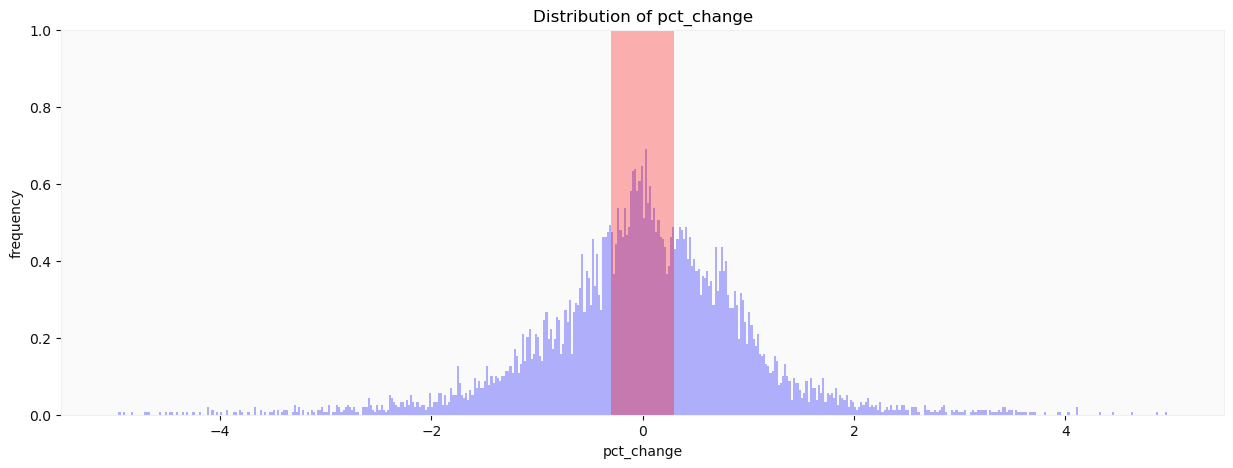

In [8]:
plot_histogram(creater.estimate_diff(train_df), mean, std, threshold=threshold)

matched / total: 630 / 1595 (39.498%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

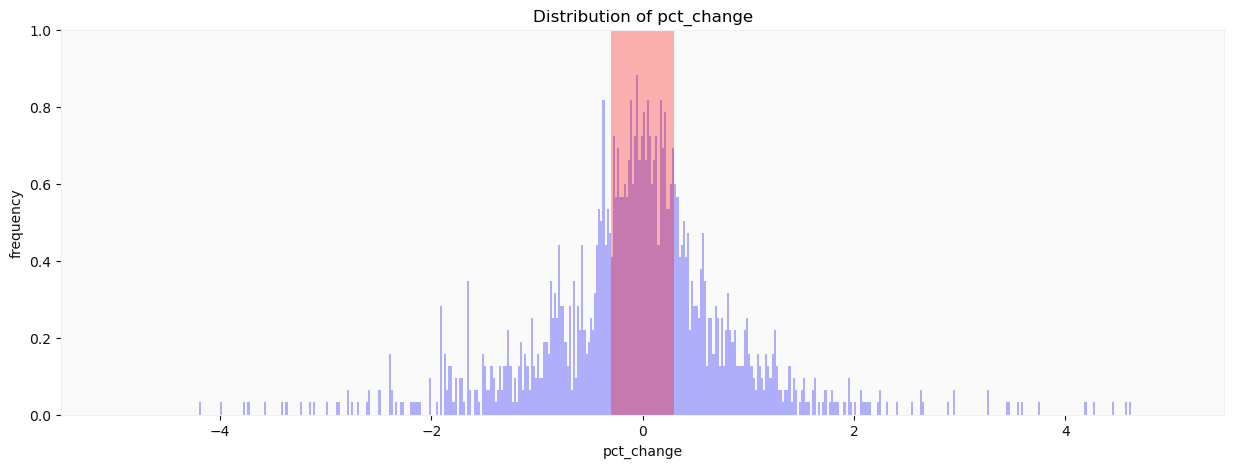

In [9]:
plot_histogram(creater.estimate_diff(test_df), mean, std, threshold=threshold)